# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p}),
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$, to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y),
\end{equation}

gdzie $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia: "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego, czy otoczenie jest względnie jednorodne, czy zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze, np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p}),
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$,
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a jaka dla skrajnie różnych (różnica 255, 200).

## Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu _scipy_:
```
    from scipy.io import loadmat
    mat = loadmat('MR_data.mat')
```

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
```
    input = mat['I_noisy1']
```

3. Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?


---

#### Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a jaka dla skrajnie różnych (różnica 255, 200).

W przypadku proponowanej funkcji $\gamma$, dla podobnych pikseli jej wartość będzie względnie duża (bliska 1, jako że wykładnik będzie bliski zeru), natomiast dla dużych różnic pikseli wykładnik potęgi będzie "większą" liczbą (ale na minusie), więc i wartość funkcji będzie mniejsza - już dla rzędu dziesiątek jest praktycznie równa 0.

---


In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'
fileNames = ["MR_data.mat"]

for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, 'wb').write(r.content)

In [2]:
# pomocnicza funkcja do wyświetlenia badanego obrazu
def show_image(image, name):
    plt.title(f"{name} image")
    plt.imshow(image, 'gray')
    plt.axis('off')

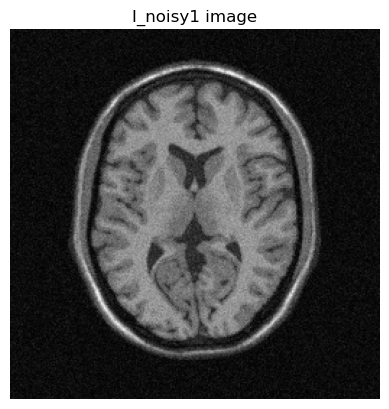

In [3]:
# wczytanie danych
mat = loadmat('MR_data.mat')

# odczytanie wybranego obrazu
noisy1 = mat['I_noisy1']

# wyświetlmy wczytany obraz
show_image(noisy1, 'I_noisy1')


---

#### Zagadka - co to za obrazowanie medyczne?

Jest to obrazowanie medyczne _MRI_ (rezonans magenetyczny).

---


### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: **rozmiar okna** i **wariancję $\delta_S$**.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli `for`).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = input.copy()`.
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [4]:
# funkcja obliczająca współczynniki filtra Gaussowskiego
def gaussian_filter(window, delta_s):
    coeffs = np.zeros((window, window))
    
    for i in range(-window // 2, window // 2 + 1):
        for j in range(-window // 2, window // 2 + 1):
            coeffs[i + window // 2, j + window // 2] = np.exp(-np.linalg.norm([i**2, j**2]) / (2 * delta_s**2))

    return coeffs

In [5]:
# funkcja wizualizująca filtr Gaussowski
def visualize_filter(coeffs, window):
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    
    X = np.arange(-(window // 2), window // 2 + 1, 1)
    Y = np.arange(-(window // 2), window // 2 + 1, 1)
    X, Y = np.meshgrid(X, Y)
    Z = coeffs
    
    ax.plot_surface(X, Y, Z)
    plt.show()

In [6]:
# algorytm klasycznej konwolucji
def classic_convolution(image, window, coeffs):
    # kopia obrazu
    image_conv = image.copy()

    # pobranie wymiarów obrazu
    H, W = image.shape
    
    for i in range(window // 2, H - window // 2):
        for j in range(window // 2, W - window // 2):
            # aktualny kontekst
            context = image[i-window//2 : i+1+window//2, j-window//2 : j+1+window//2]
            
            image_conv[i, j] = new_pixel_value_conv(context, coeffs)

    return image_conv

In [7]:
# funkcja obliczająca nową wartość piksela - konwolucja
def new_pixel_value_conv(context, coeffs):
    Wn = coeffs.sum()
    result = 1 / Wn * np.sum(coeffs * context)
    return result

In [8]:
# funkcja do porównania obrazu oryginalnego i przefiltrowanego
def compare(original, filtered):
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(18, 6)
    
    axs[0].set_title("Original image")
    axs[0].imshow(original, 'gray', vmin=0, vmax=255)
    axs[0].axis('off')
    
    axs[1].set_title("Filtered image")
    axs[1].imshow(filtered, 'gray', vmin=0, vmax=255)
    axs[1].axis('off')
    
    axs[2].set_title("Absolute difference")
    axs[2].imshow(np.abs(filtered - original), 'gray')
    axs[2].axis('off')
    
    plt.show()

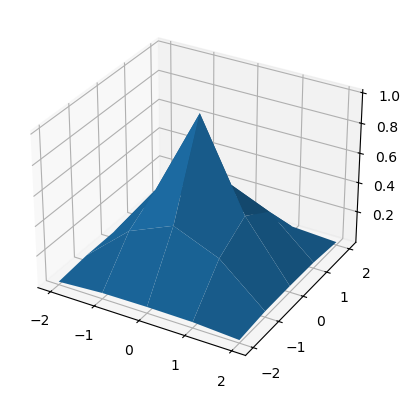

In [9]:
# parametry filtra Gaussowskiego
window = 5
delta_s = 0.75

# obliczanie współczynników filtra
coeffs = gaussian_filter(window, delta_s)

# wizualizacja filtra
visualize_filter(coeffs, window)

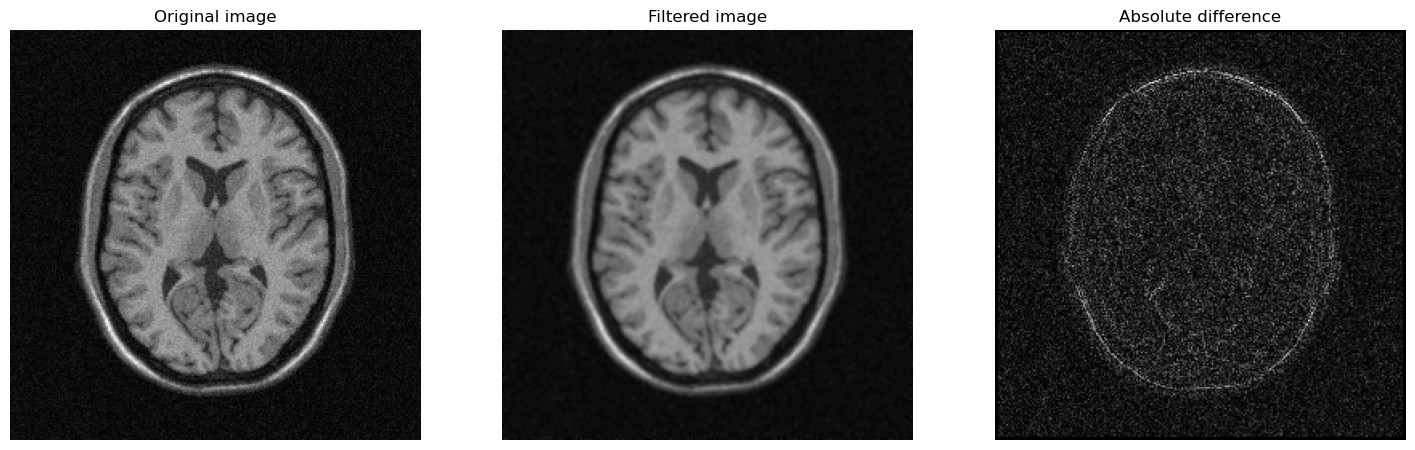

In [10]:
# wykonanie algorytmu
noisy1_conv = classic_convolution(noisy1, window, coeffs)

# wyświetlenie wyniku filtracji i porównanie z obrazem oryginalnym
compare(noisy1, noisy1_conv)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
2. Wykonaj kopię obrazu wejściowego: `IBilateral = input.copy()`.
3. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
4. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
5. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gaussowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
6. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
7. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
8. Wykonaj normalizację obliczonych współczynników.
9. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
10. Wyświetl wynik filtracji.
11. Porównaj wynik z obrazem oryginalnym.

In [11]:
# algorytm filtracji bilateralnej
def bilateral_filtering(image, window, delta_r, coeffs):
    # kopia obrazu
    image_bilateral = image.copy()

    # pobranie wymiarów obrazu
    H, W = image.shape
    
    for i in range(window // 2, H - window // 2):
        for j in range(window // 2, W - window // 2):
            # aktualny kontekst
            context = image[i-window//2 : i+1+window//2, j-window//2 : j+1+window//2]
            
            image_bilateral[i, j] = new_pixel_value_bilateral(context, coeffs, delta_r)

    return image_bilateral

In [12]:
# funkcja obliczająca nową wartość piksela - filtracja bilateralna
def new_pixel_value_bilateral(context, coeffs, delta_r):
    # obliczanie nowych współczynników filtra
    new_coeffs = coeffs.copy()
    window = coeffs.shape[0]
    
    for i in range(window):
        for j in range(window):
            new_coeffs[i, j] *= dist(context[i, j].astype(np.int32) - context[window//2, window//2].astype(np.int32), delta_r)
    
    Wn = new_coeffs.sum()
    result = 1 / Wn * np.sum(new_coeffs * context)
    return result

In [13]:
# funkcja obliczająca odległość w przeciwdziedzinie obrazu
def dist(y, delta_r):
    return np.exp(-y**2 / (2 * delta_r**2))

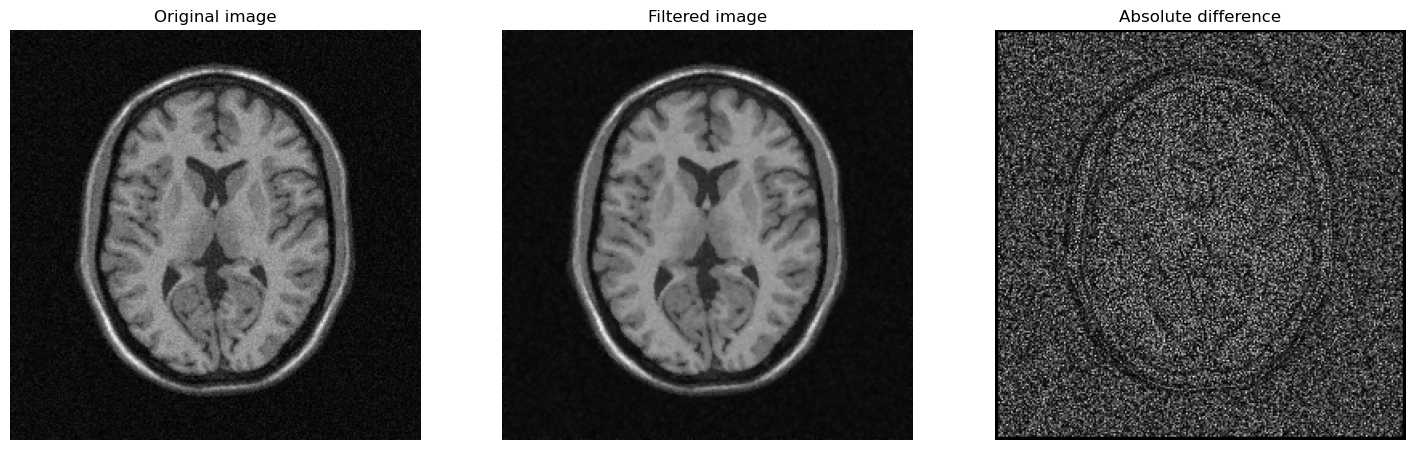

In [14]:
# dodatkowy parametr
delta_r = 20.0

# wykonanie algorytmu
noisy1_bilateral = bilateral_filtering(noisy1, window, delta_r, coeffs)

# wyświetlenie wyniku filtracji i porównanie z obrazem oryginalnym
compare(noisy1, noisy1_bilateral)

### Eksperymenty dla pozostałych obrazów

#### _I_noisefree_

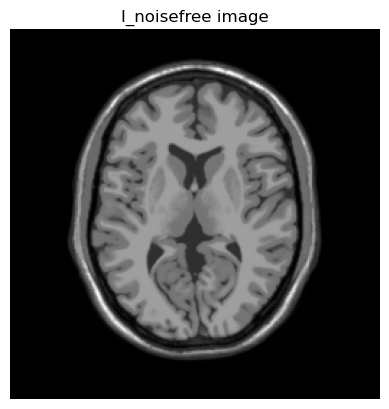

In [15]:
noisefree = mat['I_noisefree']
show_image(noisefree, 'I_noisefree')

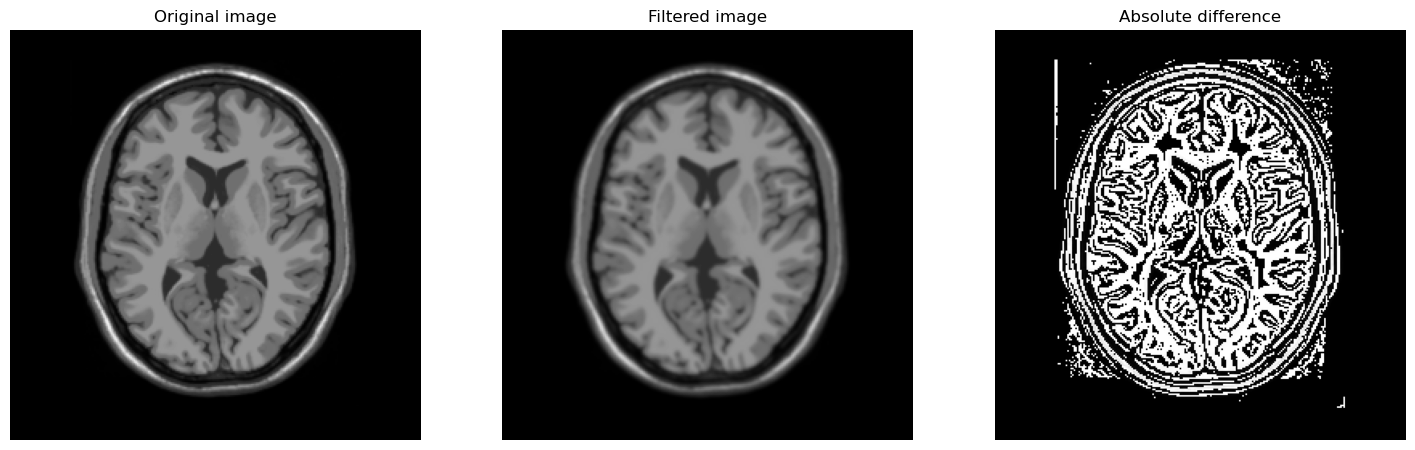

In [16]:
# klasyczna konwolucja
noisefree_conv = classic_convolution(noisefree, window, coeffs)
compare(noisefree, noisefree_conv)

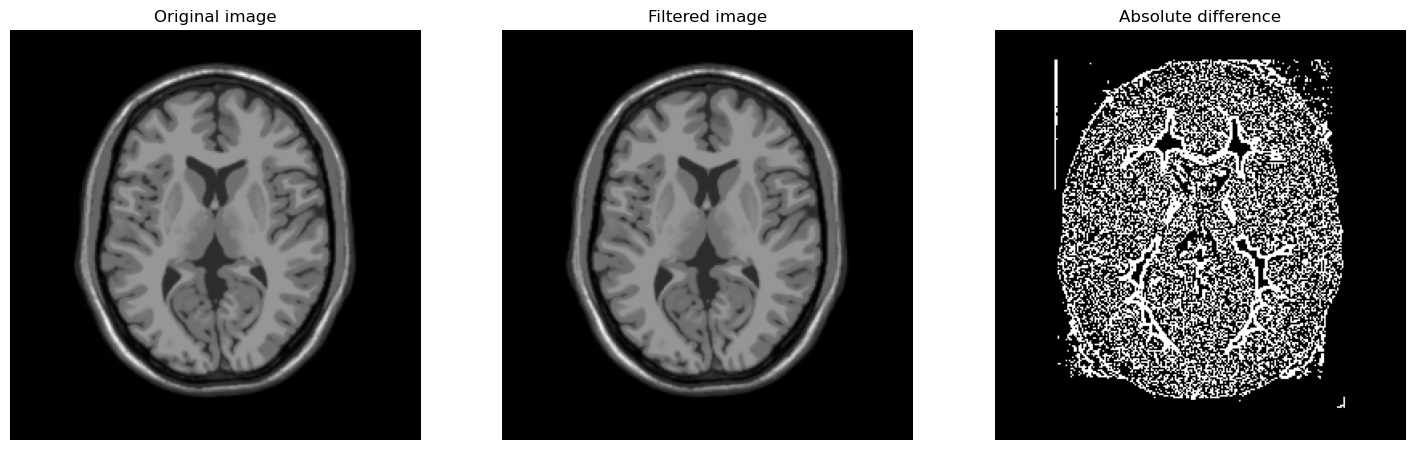

In [17]:
# filtracja bilateralna
delta_r = 0.5
noisefree_bilateral = bilateral_filtering(noisefree, window, delta_r, coeffs)
compare(noisefree, noisefree_bilateral)

#### _I_noisy2_

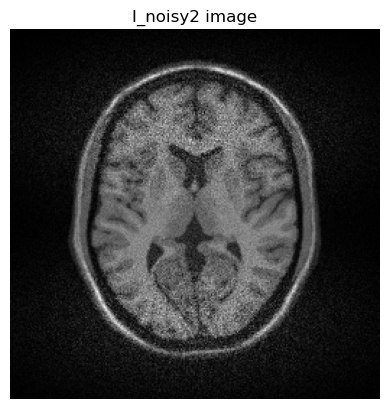

In [18]:
noisy2 = mat['I_noisy2']
show_image(noisy2, 'I_noisy2')

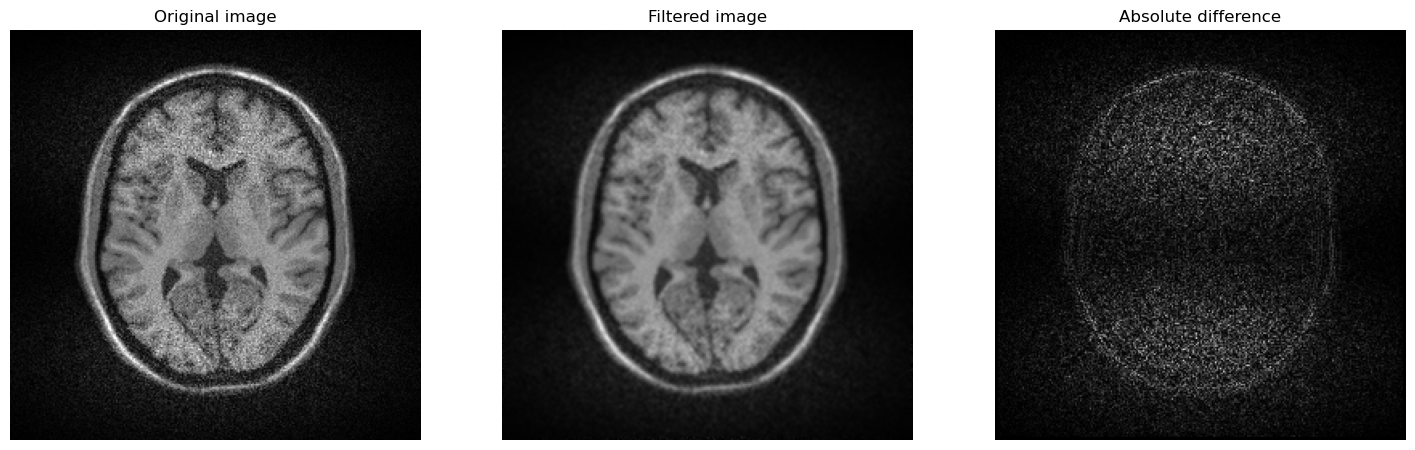

In [19]:
# klasyczna konwolucja
noisy2_conv = classic_convolution(noisy2, window, coeffs)
compare(noisy2, noisy2_conv)

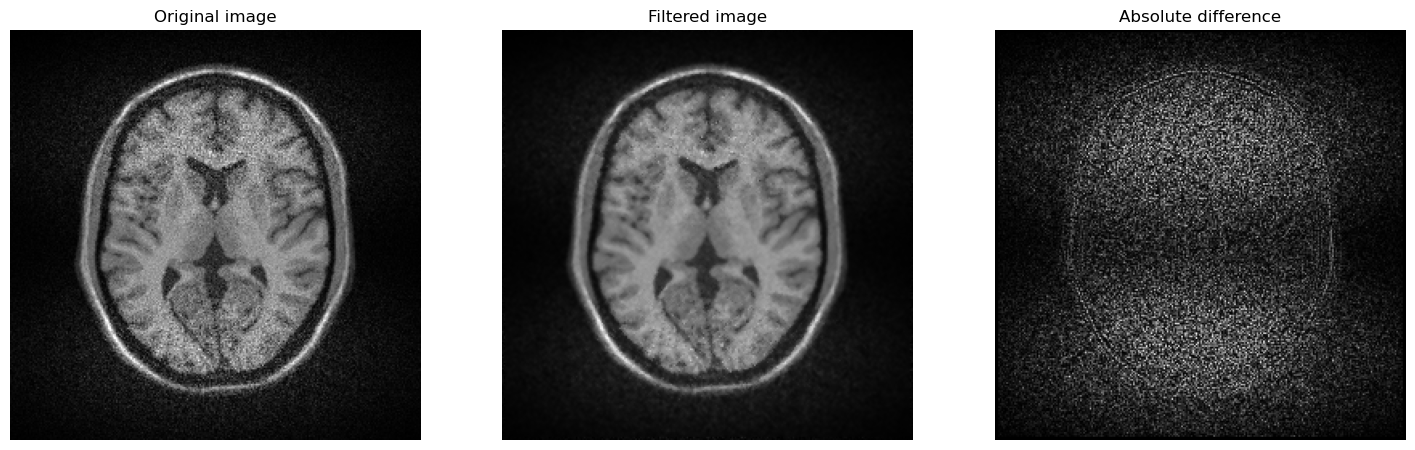

In [20]:
# filtracja bilateralna
delta_r = 60.0
noisy2_bilateral = bilateral_filtering(noisy2, window, delta_r, coeffs)
compare(noisy2, noisy2_bilateral)

#### _I_noisy3_

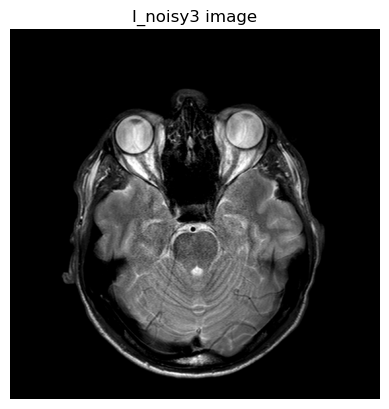

In [21]:
noisy3 = mat['I_noisy3']
show_image(noisy3, 'I_noisy3')

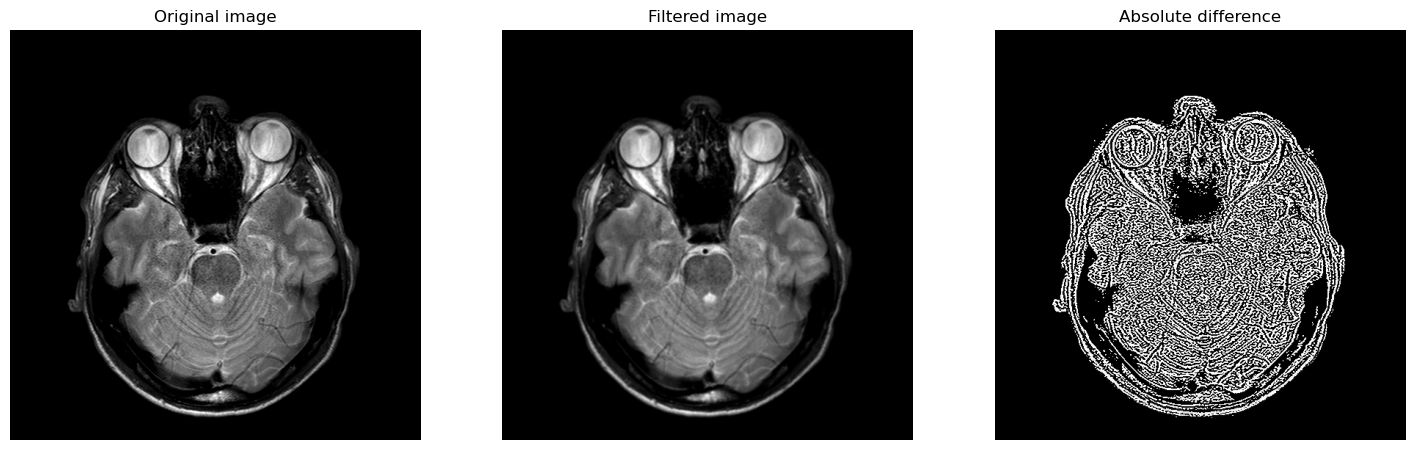

In [22]:
# klasyczna konwolucja
noisy3_conv = classic_convolution(noisy3, window, coeffs)
compare(noisy3, noisy3_conv)

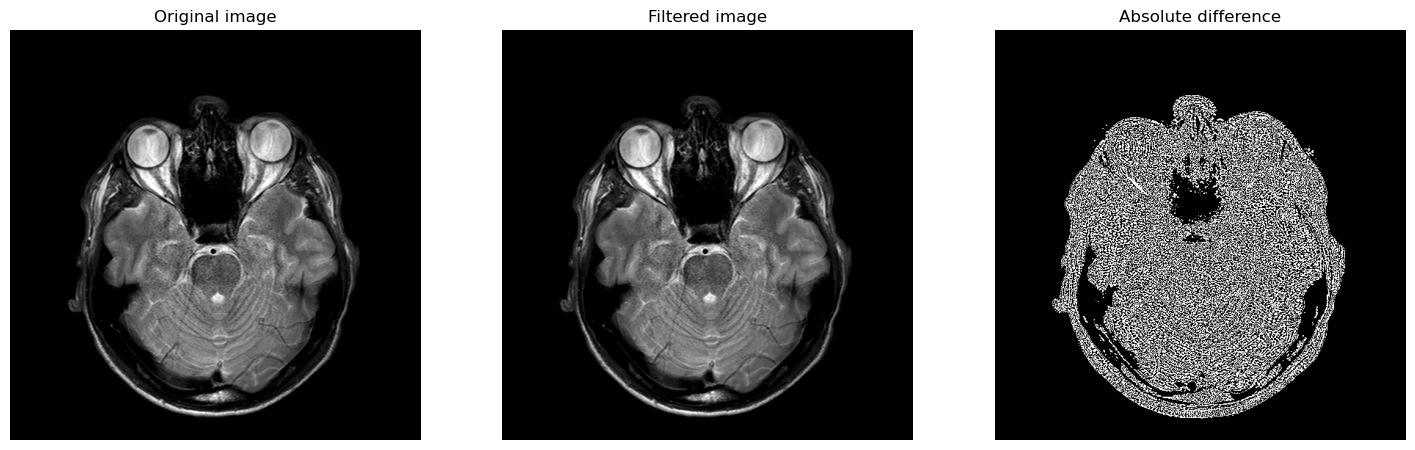

In [23]:
# filtracja bilateralna
delta_r = 5.0
noisy3_bilateral = bilateral_filtering(noisy3, window, delta_r, coeffs)
compare(noisy3, noisy3_bilateral)

#### _I_noisy4_

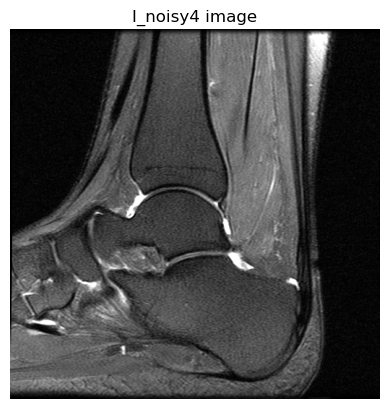

In [24]:
noisy4 = mat['I_noisy4']
show_image(noisy4, 'I_noisy4')

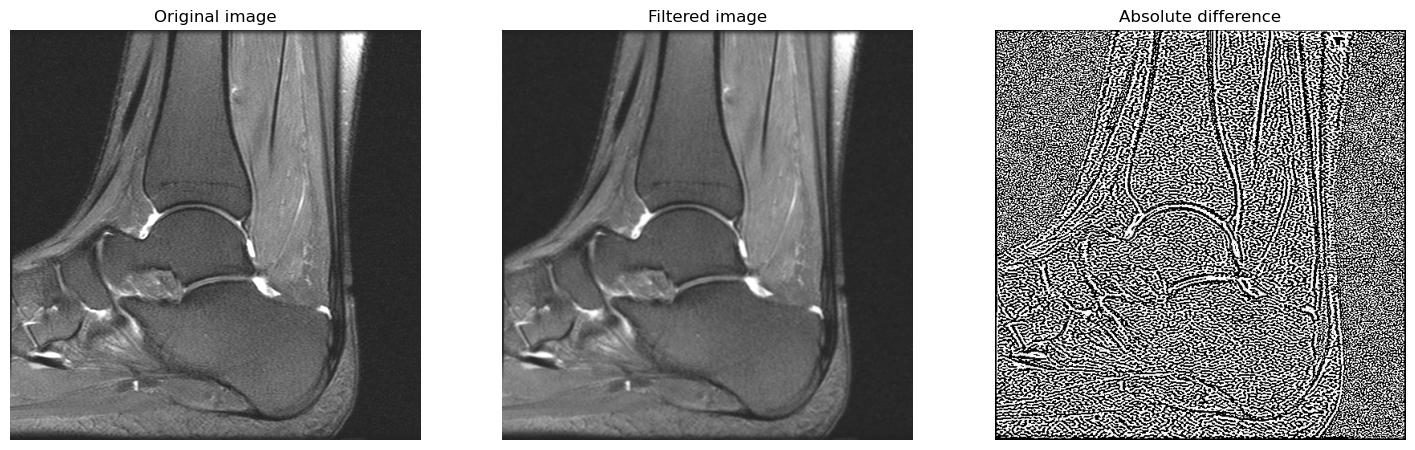

In [25]:
# klasyczna konwolucja
noisy4_conv = classic_convolution(noisy4, window, coeffs)
compare(noisy4, noisy4_conv)

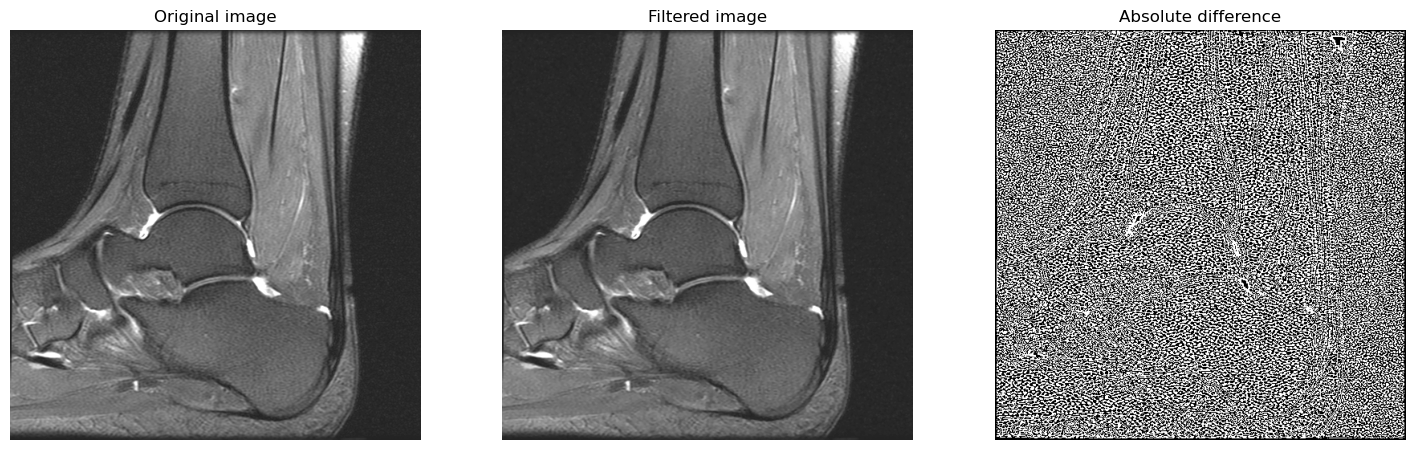

In [26]:
# filtracja bilateralna
noisy4_bilateral = bilateral_filtering(noisy4, window, delta_r, coeffs)
compare(noisy4, noisy4_bilateral)